## 相关性分析
数据集包含 13 个特征 (CRIM, ZN, INDUS, ... LSTAT)，以及目标变量 MEDV（房价）
计算这些特征与 MEDV 的相关性，选取与房价最相关的特征用于训练神经网络。
分别计算三种相关性分析算法的结果，然后求交集，选取求交集后的7个特征用来拟合


In [1]:
import pandas as pd

# 读取 Excel 文件
file_path = "BostonHousingData.xlsx"
xls = pd.ExcelFile(file_path)

# 查看数据集包含的所有 sheet
xls.sheet_names

# 读取数据
df = pd.read_excel(xls, sheet_name="Sheet1")

# 计算特征与目标变量 MEDV 的相关性
correlation_matrix_pearson = df.corr(method="pearson")
correlation_matrix_kendall = df.corr(method="kendall")
correlation_matrix_spearman = df.corr(method="spearman")

# 按相关性大小排序，查看与 MEDV 相关性最高的特征
N=8 # N<=13 取出前 N 个（N//2 个正相关，（N+1）//2个负相关）相关性最大的特征，然后求交集
corr_features_pearson = correlation_matrix_pearson["MEDV"].sort_values(ascending=False)
corr_features_pearson = list(corr_features_pearson.index)
corr_features_pearson = corr_features_pearson[1:N//2+1] + corr_features_pearson[-(N+1)//2:]
corr_features_kendall = correlation_matrix_kendall["MEDV"].sort_values(ascending=False)
corr_features_kendall = list(corr_features_kendall.index)
corr_features_kendall = corr_features_kendall[1:N//2+1] + corr_features_kendall[-(N+1)//2:]
corr_features_spearman = correlation_matrix_spearman["MEDV"].sort_values(ascending=False)
corr_features_spearman = list(corr_features_spearman.index)
corr_features_spearman = corr_features_spearman[1:N//2+1] + corr_features_spearman[-(N+1)//2:]
# assert set(corr_features_pearson.index) == set(corr_features_kendall.index) == set(corr_features_spearman.index)
print(corr_features_pearson)
print(corr_features_kendall)
print(corr_features_spearman)
corr_features_selected = list(set(corr_features_pearson) & set(corr_features_kendall) & set(corr_features_spearman))
print(corr_features_selected)

['RM', 'ZN', 'B', 'DIS', 'NOX', 'TAX', 'INDUS', 'PTRATIO', 'LSTAT']
['RM', 'ZN', 'DIS', 'B', 'PTRATIO', 'CRIM', 'TAX', 'INDUS', 'LSTAT']
['RM', 'DIS', 'ZN', 'B', 'CRIM', 'TAX', 'NOX', 'INDUS', 'LSTAT']
['DIS', 'LSTAT', 'INDUS', 'ZN', 'B', 'RM', 'TAX']


## 构建NN
分为

a) 数据准备：将波士顿房价数据集的前450条作为训练集，后50条作为测试集。

b) 数据预处理：对训练集和测试集的特征进行预处理（如：对缺失值进行处理），
确保输入数据有相同的维度。

c) 神经网络构建：在Python中使用Pytorch等神经网络框架构建一个适合回归
问题的神经网络模型，包括输入层、隐藏层和输出层。可以选择使用多个隐藏层
和不同的激活函数测试效果。

d) 模型训练：使用训练集对神经网络模型进行训练，通过反向传播算法更新权
重和偏置。

e) 模型测试和评估：使用测试集对训练好的神经网络模型进行测试，计算预测
值与实际值之间的均方误差作为评价指标

### 数据准备


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# # 读取数据
# df = pd.read_excel("BostonHousingData.xlsx")

# 选择相关性最高的特征
selected_features = corr_features_selected
X = df[selected_features].values
y = df["MEDV"].values

# 划分训练集（前450条）和测试集（后50条）
X_train, X_test = X[:450], X[450:]
y_train, y_test = y[:450], y[450:]


### 数据预处理


In [3]:
# 确保数据有相同维度
assert X_train.shape[1] == X_test.shape[1], "训练集和测试集特征维度不一致"
assert y_train.shape[0] == X_train.shape[0], "训练集和测试集目标变量维度不一致"
print(f"训练集特征维度: {X_train.shape}, 目标变量维度: {y_train.shape}")
print(f"测试集特征维度: {X_test.shape}, 目标变量维度: {y_test.shape}")
# 数据标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


训练集特征维度: (450, 7), 目标变量维度: (450,)
测试集特征维度: (56, 7), 目标变量维度: (56,)


### 构建神经网络


In [4]:

# 转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 定义神经网络模型
class HousePriceNN(nn.Module):
    def __init__(self):
        super(HousePriceNN, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(len(corr_features_selected), 16),  # 输入层 -> 隐藏层1
            nn.ReLU(),
            nn.Linear(16, 32),  # 隐藏层1 -> 隐藏层2
            nn.BatchNorm1d(32),  # 批归一化
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout

            nn.Linear(32, 1024),  # 隐藏层2 -> 隐藏层3
            nn.BatchNorm1d(1024),  # 批归一化
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout

            nn.Linear(1024, 1024),  # 隐藏层3 -> 隐藏层4
            nn.BatchNorm1d(1024),  # 批归一化
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout

            nn.Linear(1024, 512),  # 隐藏层4 -> 隐藏层5
            nn.BatchNorm1d(512),  # 批归一化
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout
            nn.Linear(512, 256),  # 隐藏层5 -> 隐藏层6
            nn.BatchNorm1d(256),  # 批归一化
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout
            nn.Linear(256, 8),  # 隐藏层6 -> 隐藏层7
            nn.BatchNorm1d(8),  # 批归一化
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout

            nn.Linear(8, 1)  # 隐藏层7 -> 输出层
        )

    def forward(self, x):
        return self.model(x)

# 创建模型
model = HousePriceNN()

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


### 模型训练


In [5]:

# 训练模型
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")



Epoch [50/500], Loss: 340.0873
Epoch [100/500], Loss: 83.5387
Epoch [150/500], Loss: 35.4970
Epoch [200/500], Loss: 26.9299
Epoch [250/500], Loss: 24.4634
Epoch [300/500], Loss: 27.0834
Epoch [350/500], Loss: 30.9956
Epoch [400/500], Loss: 22.9931
Epoch [450/500], Loss: 21.0940
Epoch [500/500], Loss: 29.8310


### 模型测试与评估


Test MSE: 11.9416
Test RMSE: 3.4557
Test MAPE: 15.21%
Test R² Score: 0.3464


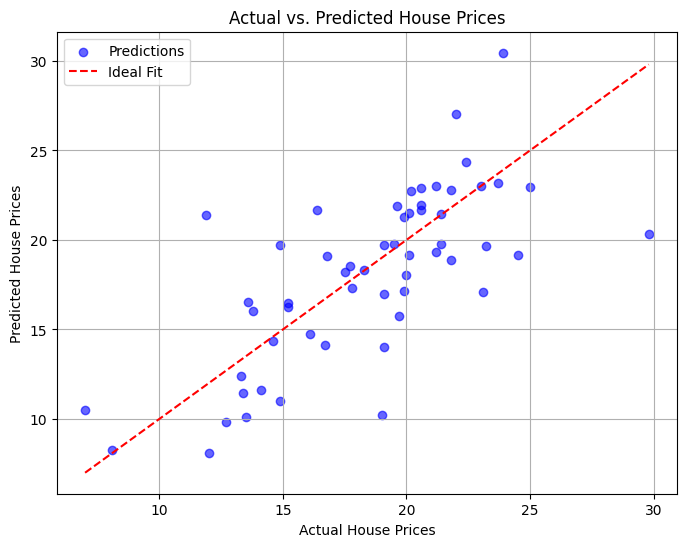

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 模型测试与评估
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).numpy().flatten()
    y_test_true = y_test_tensor.numpy().flatten()

# 计算均方误差（MSE）和均方根误差（RMSE）
mse = mean_squared_error(y_test_true, y_test_pred)
rmse = np.sqrt(mse)

# 计算均方百分比误差（MAPE）
mape = np.mean(np.abs((y_test_true - y_test_pred) / y_test_true)) * 100

# 计算 R² 决定系数
r2 = r2_score(y_test_true, y_test_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test R² Score: {r2:.4f}")

# 绘制真实值 vs. 预测值的散点图
plt.figure(figsize=(8, 6))
plt.scatter(y_test_true, y_test_pred, alpha=0.6, color="blue", label="Predictions")
plt.plot([min(y_test_true), max(y_test_true)], [min(y_test_true), max(y_test_true)], color='red', linestyle='--', label="Ideal Fit")
plt.xlabel("Actual House Prices")
plt.ylabel("Predicted House Prices")
plt.title("Actual vs. Predicted House Prices")
plt.legend()
plt.grid()
plt.show()
